In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.impute import SimpleImputer



Load the Dataset

In [51]:
apps_data = pd.read_csv("../data/combined/combined_apps.csv")
apps_data.head()

,package_name,category,license,source_code,author,suggested_version,anti_features,anti_feature_score,added_date,last_updated_date,...,rating,reviews,size_mb,installs_clean,type,price_clean,content_rating,genres,current_ver,android_ver
0,info.puzz.a10000sentences,Science & Education,Apache-2.0,https://github.com/tkrajina/10000sentences,SCIO,0.3.4,NonFreeNet,1,2019-09-18T17:00:00,2019-09-18 17:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,com.github.ashutoshgngwr.tenbitclockwidget,"Theming, Time",GPL-3.0-only,https://github.com/ashutoshgngwr/10-bitClockWi...,NaN,2.2-1,NaN,0,2020-10-01T17:00:00,2023-10-08 11:25:01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dev.lonami.klooni,Games,GPL-3.0-or-later,https://github.com/LonamiWebs/Klooni1010,NaN,0.8.6,NaN,0,2020-05-08T17:00:00,2020-08-31 17:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,eu.quelltext.counting,"Games, Science & Education",AGPL-3.0-or-later,https://gitlab.com/niccokunzmann/12345,Nicco Kunzmann,1.3,NaN,0,2022-03-01T16:00:00,2022-03-03 16:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,com.lucasdnd.bitclock16,Time,GPL-2.0-or-later,https://github.com/lucasdnd/16-bit-clock,NaN,1.0,NaN,0,2015-03-29T17:00:00,2015-03-29 17:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Create a binary flag for Free vs. Paid apps based on the 'type' column
apps_data['paid_flag'] = apps_data['type'].apply(lambda x: 0 if 'free' in str(x).lower() else 1)

print("Paid flag sample:")
print(apps_data[['app_name', 'type', 'paid_flag']].head())

Paid flag sample:
                 app_name type  paid_flag
0        10,000 sentences  NaN          1
1     10-bit Clock Widget  NaN          1
2            1010! Klooni  NaN          1
3  12345 - Learn Counting  NaN          1
4     16-bit Clock Widget  NaN          1


In [53]:
apps_data.columns


Index(['package_name', 'category', 'license', 'source_code', 'author',
       'suggested_version', 'anti_features', 'anti_feature_score',
       'added_date', 'last_updated_date', 'update_freq_days', 'app_name',
       'summary', 'description', 'price_tier', 'platform', 'app_age_days',
       'rating', 'reviews', 'size_mb', 'installs_clean', 'type', 'price_clean',
       'content_rating', 'genres', 'current_ver', 'android_ver', 'paid_flag'],
      dtype='object')

Define Features + Target (Classification)

In [54]:
features = ["size_mb", "update_freq_days", "anti_feature_score", "category", "paid_flag", "reviews", "installs_clean"] #optionally add a price feature for better predictions
target = "platform"  # 0 = F-Droid, 1 = Google Play

X = apps_data[features]
y = apps_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create Preprocessor

In [55]:
numeric_features = ["size_mb", "update_freq_days", "anti_feature_score", "paid_flag", "reviews", "installs_clean"]
categorical_features = ["category"]

# Numeric pipeline with imputer + scaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline with imputer + one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into one preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

Classification Pipeline

In [56]:
numeric_imputer = SimpleImputer(strategy="mean")
categorical_imputer = SimpleImputer(strategy="constant", fill_value="missing")

# Update transformers to include imputation
numeric_transformer = Pipeline(steps=[
    ("imputer", numeric_imputer),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", categorical_imputer),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


Regression Pipeline (for predicting ratings)

In [57]:
target = "rating"
apps_data = apps_data.dropna(subset=["rating"])
X = apps_data[features]
y = apps_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

reg_pipeline.fit(X_train, y_train)
y_pred = reg_pipeline.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 0.46
R²: 0.14


Feature Importance visualization

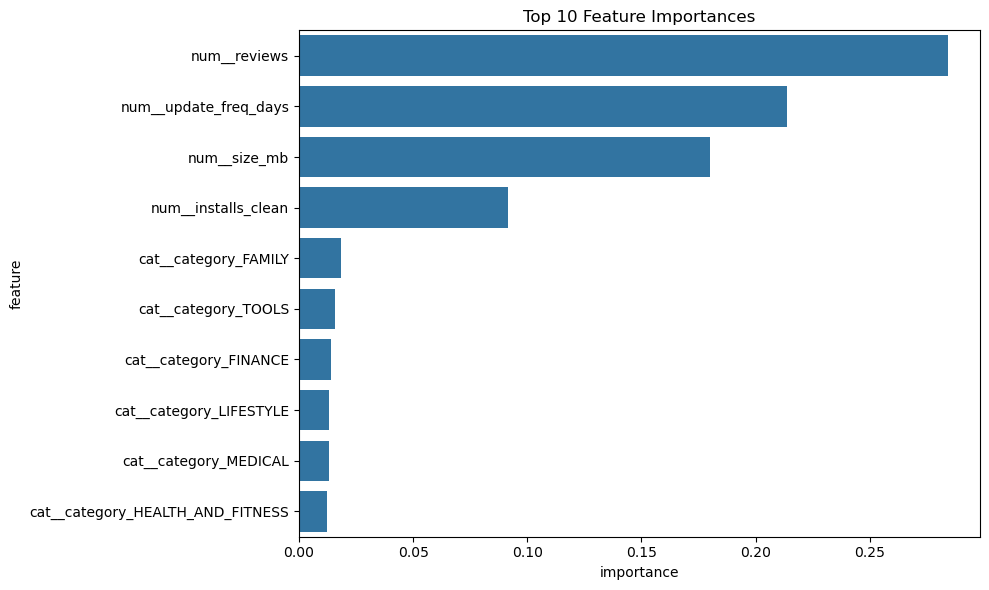

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = reg_pipeline.named_steps["regressor"].feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Combine and sort
feat_df = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_df = feat_df.sort_values("importance", ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feat_df.head(10))
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


Classification Pipeline (for predicting platform)

Classification Report:
               precision    recall  f1-score   support

 Google Play       1.00      1.00      1.00      1874

    accuracy                           1.00      1874
   macro avg       1.00      1.00      1.00      1874
weighted avg       1.00      1.00      1.00      1874



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


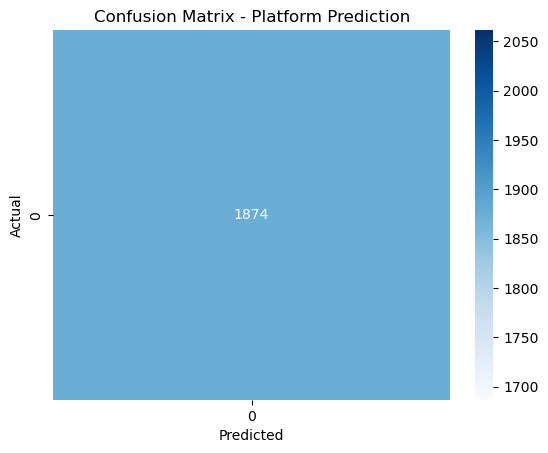

In [ ]:
target = "platform"
apps_data = apps_data.dropna(subset=[target])

y = apps_data[target].astype(str)
X = apps_data[features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

clf_pipeline.fit(X_train, y_train)
print(classification_report(y_test, clf_pipeline.predict(X_test)))

y_pred = clf_pipeline.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Platform Prediction")
plt.show()


